In [2]:
from scipy.optimize import minimize
import numpy as np
import pickle
import json
import torch
import matplotlib.pyplot as plt
from tools.attributes_dict import attr_list

In [3]:
combined_path = "./data/combined/dataset.pkl"
peta_path = "./data/PETA/dataset.pkl"
pa100k_path = "./data/PA100k/dataset.pkl"
neolix_path = "./data/neolix/dataset.pkl"

combined_dataset = pickle.load(open(combined_path, 'rb+'))
peta_dataset = pickle.load(open(peta_path, 'rb+'))
neolix_dataset = pickle.load(open(neolix_path, 'rb+'))

In [ ]:
dataset_label = combined_dataset.label
dataset_size = dataset_label.shape[0]
label_num = dataset_label.shape[1]
e = torch.tensor(0.001)
N = dataset_size
M = label_num
A = torch.from_numpy(dataset_label)
one_arr = torch.ones(1,M)
def func(x):
    p =  torch.div(torch.sum(torch.mul(torch.mm(x.reshape(-1,1), one_arr), A), 0), (torch.sum(x.flatten())))
    m = (0.6-p).reshape(-1,1)
    # m3 = m*m*m
    # m3[m3<0] = 0
    # f = torch.sum(m3, 0) - torch.mm(0.001*torch.ones(M,N),x)
    # m[m<0] = 0
    m_2 = m*m
    f = torch.sum(m_2, 0) + 0.1 * torch.max(x) / (torch.min(x) + e) 
    print(torch.sum(m_2, 0), torch.max(x) / (torch.min(x) + e))
    return f

x=torch.ones((N,1),requires_grad=True)
optimizer=torch.optim.Adam([x],lr=1e-3)
for step in range(20000):
    loss=func(x)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    x_ = x.detach()
    x_[x_<0] = 0
    # w1.data.sub_(lr*w1.grad.data)
    if step % 2000==0:
        print("step:",step,"loss:",loss) #,x.tolist()
print("final_loss:",loss,x)
np.save("combined_test.npy",x.detach().numpy())

In [15]:
p = torch.div(torch.sum(torch.mul(torch.mm(x.reshape(-1,1), one_arr), A), 0), (torch.sum(x.flatten())))
op = np.sum(dataset_label, 0) / N
# op = np.sum(peta_dataset.label, 0) / N
print( "原来各属性概率", op,"\n预计采样后各属性概率",p)
np.set_printoptions(threshold=np.inf)
y = x.detach().numpy()
print(y.shape, y, np.sum(y,0))
# 化为整数
q = (10 * y).astype(int)
print(q.reshape(4,-1), np.bincount(q.flatten()), np.max(q), np.sum(q))

torch.Size([119000, 1]) tensor([[0.0316],
        [0.0227],
        [0.0310],
        ...,
        [0.0000],
        [0.0000],
        [0.0000]], requires_grad=True) tensor([0.5960, 0.2029, 0.6012, 0.2451, 0.1388, 0.3650, 0.3284, 0.3065, 0.3396,
        0.3483, 0.1836, 0.2971, 0.4680, 0.5278, 0.2106, 0.0275, 0.0339, 0.2626,
        0.0968, 0.2198, 0.0285, 0.1472, 0.2139, 0.1457, 0.0719, 0.0424, 0.1332,
        0.0410, 0.0819, 0.0417, 0.0758, 0.2499, 0.0304, 0.4696, 0.3240, 0.2494,
        0.1204, 0.3298, 0.1286, 0.0607, 0.0224, 0.1656, 0.0370, 0.0654, 0.0247,
        0.0627, 0.0979, 0.0291], grad_fn=<DivBackward0>) 
 [0.44612605 0.04921849 0.86434454 0.09940336 0.02219328 0.34546218
 0.304      0.35053782 0.16521849 0.20941176 0.05156303 0.17052101
 0.50090756 0.49542857 0.16177311 0.00618487 0.00484034 0.40783193
 0.01534454 0.25070588 0.02047059 0.04264706 0.3472605  0.08660504
 0.01957143 0.01956303 0.11217647 0.00701681 0.04531092 0.01877311
 0.05663025 0.28842857 0.01720168 0.6865

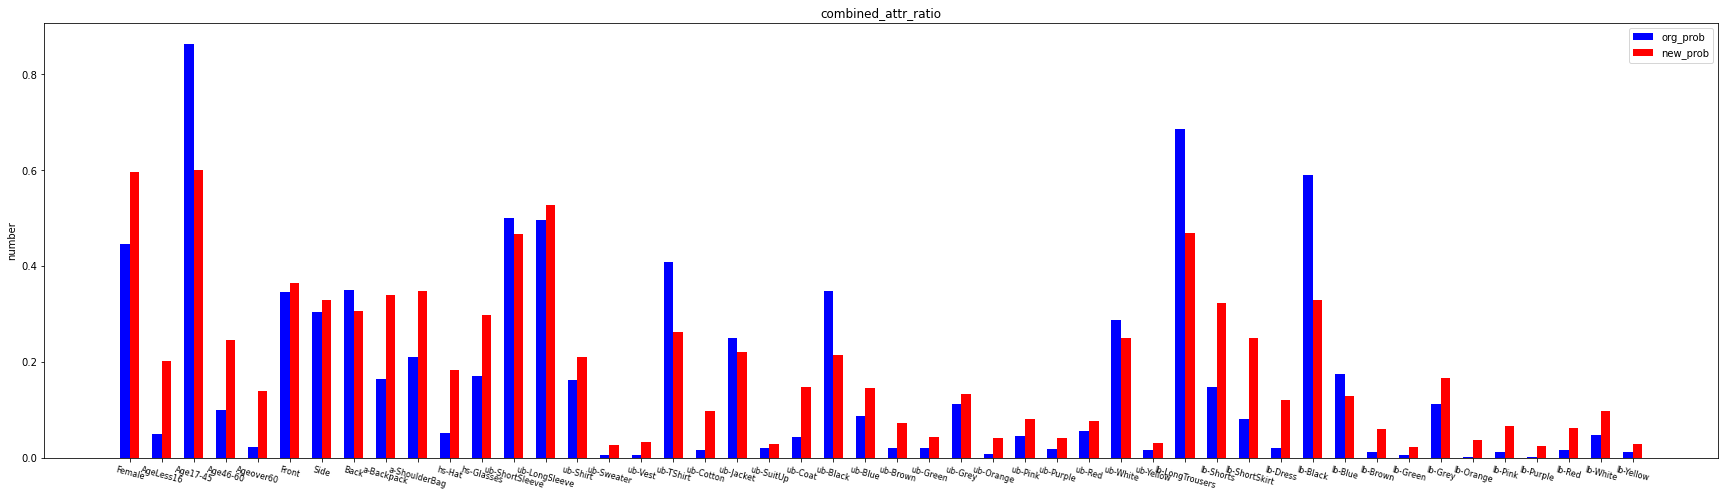

In [16]:
# 显示各个属性概率
attr = attr_list

bar_width = 0.3
index_op = np.arange(len(attr))
index_p = np.arange(len(attr)) + bar_width

plt.figure(figsize = (30,8))
plt.bar(index_op, height = op, width=bar_width, color='b', label='org_prob')
plt.bar(index_p, height = p.detach().numpy(), width=bar_width, color='r', label='new_prob')

plt.legend()  # 显示图例
plt.xticks(index_op + bar_width/2, attr)
plt.tick_params(axis='x', labelsize=8)
plt.xticks(rotation=-15)
plt.ylabel('number')  # 纵坐标轴标题
plt.title('combined_attr_ratio')  # 图形标题
plt.savefig('./test.jpg')

plt.show()

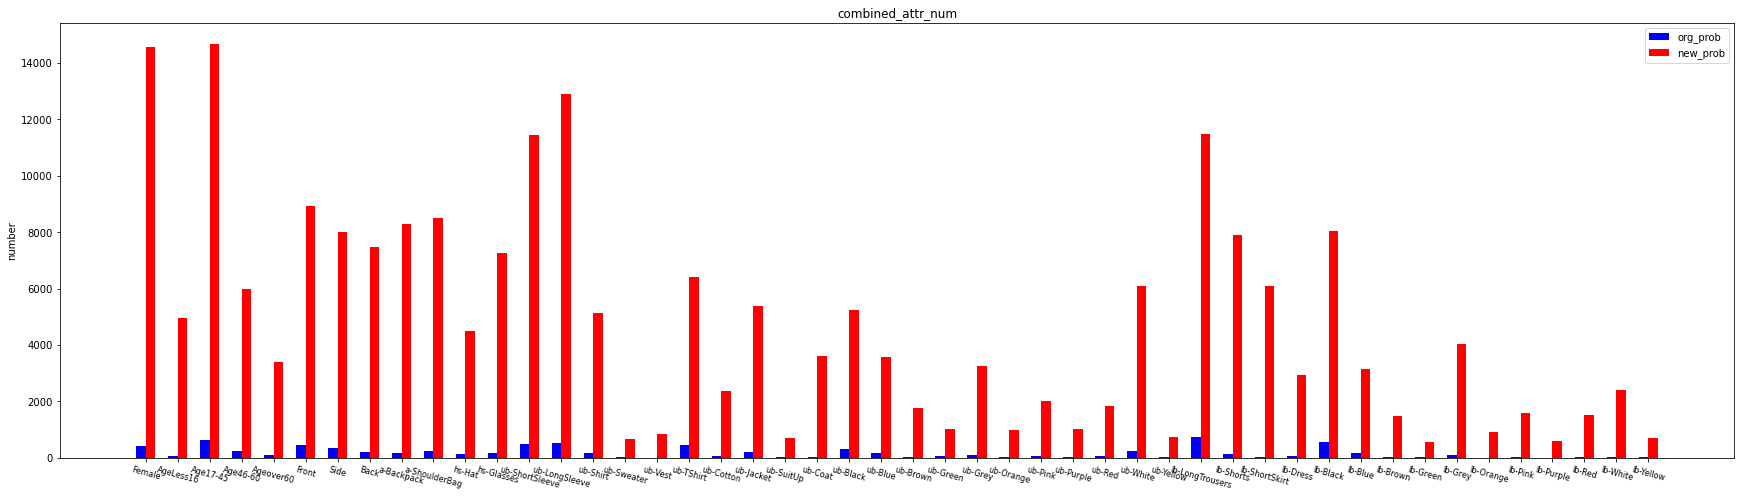

In [17]:
# 显示各个属性样本数
org_num = np.sum(dataset_label, 0)
new_num = (3*torch.sum(torch.mul(torch.mm(x.reshape(-1,1), one_arr), A), 0).detach().numpy()).astype(int)
attr = attr_list

bar_width = 0.3
index_op = np.arange(len(attr))
index_p = np.arange(len(attr)) + bar_width

plt.figure(figsize = (30,8))
plt.bar(index_op, height = org_num, width=bar_width, color='b', label='org_prob')
plt.bar(index_p, height = new_num, width=bar_width, color='r', label='new_prob')

plt.legend()  # 显示图例
plt.xticks(index_op + bar_width/2, attr) 
plt.tick_params(axis='x', labelsize=8)
plt.xticks(rotation=-15) 
plt.ylabel('number')  # 纵坐标轴标题
plt.title('combined_attr_num')  # 图形标题
plt.savefig('./test.jpg')

plt.show()

In [ ]:
# 方法1 scipy接口
# 运行慢
dataset_size = peta_dataset.label.shape[0]
label_num = peta_dataset.label.shape[1]
e = 1e-10 # 非常接近0的值
N = dataset_size
M = label_num
A = peta_dataset.label # combined_dataset.label
one_arr = np.ones((M,1))
# scipy
def func(x,l):
    p = np.sum((x.reshape(-1,1).dot(one_arr.T) * A), 0)  / (np.sum(x.flatten()))
    m = (0.6-p)**2
    # import pdb; pdb.set_trace()
    f = np.sum(m - l.dot(x))
    # m = (0.6-p)**3
    # m[m<0] = 0
    # f = np.sum((0.6-p)**2)
    return f

# fun = lambda x : np.sum((x.dot(one_arr) * A), 1)  / (np.sum(x))
cons = (
        {'type': 'ineq', 'fun': lambda l: l - e}, # x>=e，即 x > 0
        )

x0 = np.ones((N,1)) # 设置初始值
l0 = np.ones((M,N))
res = minimize(func, x0,l0, method='SLSQP', constraints=cons)
print('最小值：',res.fun)
print('最优解：',res.x)
print('迭代终止是否成功：', res.success)
print('迭代终止原因：', res.message)